In [4]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [3]:
import requests
import pandas as pd
import geohelper as geo
import os
from haystack import component

@component
class ClimateServiceAPIFetcher():

    @component.output_types(dataframe=pd.DataFrame)
    def run(self, location: object) -> pd.DataFrame:
        api_key = os.getenv("CLIMATE_SERVICE_API_KEY")
        latlong = geo.get_lat_long(location)
        start_date = "2024-01-02"
        end_date = "2080-12-31"
        url_dictionary = {
            "num_days_above_100": f"?query=annually(exceed(maxtmp,365,37),mean)&from_date={start_date}T00%3A00%3A00.000Z&to_date={end_date}T00%3A00%3A00.000Z&latitude={latlong[0]}&longitude={latlong[1]}&apikey={api_key}",
            "num_days_above_90": f"?query=annually(exceed(maxtmp,365,32.2),mean)&from_date={start_date}T00%3A00%3A00.000Z&to_date={end_date}T00%3A00%3A00.000Z&latitude={latlong[0]}&longitude={latlong[1]}&apikey={api_key}",
            "num_days_above_80": f"?query=annually(exceed(maxtmp,365,26.7),mean)&from_date={start_date}T00%3A00%3A00.000Z&to_date={end_date}T00%3A00%3A00.000Z&latitude={latlong[0]}&longitude={latlong[1]}&apikey={api_key}",
            "tempmax": f"?query=monthly(maxtmp,max)&from_date={start_date}T00%3A00%3A00.000Z&to_date={end_date}T00%3A00%3A00.000Z&latitude={latlong[0]}&longitude={latlong[1]}&apikey={api_key}",
            "tempmin": f"?query=annually(mintmp,min)&from_date={start_date}T00%3A00%3A00.000Z&to_date={end_date}T00%3A00%3A00.000Z&latitude={latlong[0]}&longitude={latlong[1]}&apikey={api_key}",
            "precip": f"?query=annually(pr,sum)&from_date={start_date}T00%3A00%3A00.000Z&to_date={end_date}T00%3A00%3A00.000Z&latitude={latlong[0]}&longitude={latlong[1]}&apikey={api_key}",
            }
        url = f'https://beta.climatedataservice.com/v6/series/csv{url_dictionary["precip"]}'
        print(url)
        df = pd.read_csv(url, skiprows=12)
        df.drop(columns=["latitude", "longitude"], inplace=True, axis=1)
        return {"dataframe":df}

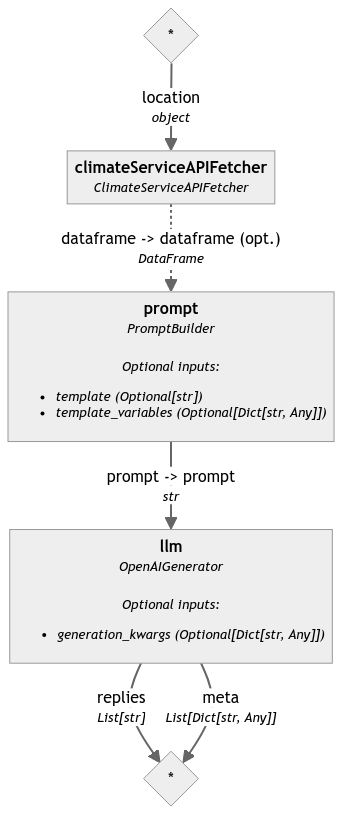

In [5]:
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack.components.generators.openai import OpenAIGenerator
from haystack import Pipeline
template="""You are a climate scientist. You will be given a dataframe with the following columns:datetime, data 
            where datetime represents a year in the future and data represents the amount of precipitation in millimeters for that year.
            Execute linear regression against this data over the entire date range, describe what is happening based on the data and provide suggestions for how to prepare a physical business or homeowner for the projected temperature changes.
            {{dataframe}}"""
prompt = PromptBuilder(template=template)
llm = OpenAIGenerator()
climateServiceAPIFetcher = ClimateServiceAPIFetcher()

climate_suggester = Pipeline()
climate_suggester.add_component("climateServiceAPIFetcher", climateServiceAPIFetcher)
climate_suggester.add_component("prompt", prompt)
climate_suggester.add_component("llm", llm)

climate_suggester.connect("climateServiceAPIFetcher.dataframe", "prompt.dataframe")
climate_suggester.connect("prompt", "llm")

climate_suggester.show()

In [6]:
output = climate_suggester.run({"climateServiceAPIFetcher": {"location": {"city_name":"Oxford", "country":"England"}}})

Oxford, Ohio, United States
https://beta.climatedataservice.com/v6/series/csv?query=annually(pr,sum)&from_date=2024-01-02T00%3A00%3A00.000Z&to_date=2080-12-31T00%3A00%3A00.000Z&latitude=39.507&longitude=-84.74523&apikey=chIG46_pdyQnpPk7YpHJxVnV6qR2pjdP2hc-dra20Nw


In [7]:
print(output["llm"]["replies"][0])

To begin, let's perform linear regression on the provided data to analyze the trend in precipitation over the years. 

Here is a summary of the linear regression analysis:
- The slope of the regression line is positive, indicating an increasing trend in precipitation over time.
- The R-squared value indicates that the linear model explains a significant portion of the variance in the data, suggesting a good fit.

Based on the data showing an increasing trend in precipitation over the years, it is important to prepare for potential impacts of climate change, including extreme weather events such as heavier rainfall. Here are some suggestions for how physical businesses or homeowners can prepare for projected temperature changes:

1. Improve drainage systems: With heavier rainfall expected, it is important to ensure that drainage systems are efficient and effective in managing excess water to prevent flooding.

2. Stronger infrastructure: Strengthening buildings and properties to withsta